In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'C:/Users/s_csmscox/jupyterSave/eye_blink/train'
validation_dir = 'C:/Users/s_csmscox/jupyterSave/eye_blink/valid'

batch_size = 1000
img_size = 32

# train_datagen = ImageDataGenerator(rescale=1/255)

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=20,  # 지정된 각도 범위내에서 임의로 원본 이미지를 회전
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,    #  1-수치 혹은 1+수치만큼 확대 및 축소
                                   )



validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),                      
    batch_size=batch_size,     
    class_mode='categorical'                    
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size,img_size),                       
    batch_size=batch_size,    
    class_mode='categorical'                    
)

Found 54332 images belonging to 2 classes.
Found 13585 images belonging to 2 classes.


# Model Train

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Nadam

# gpu 메모리 최대로 잡는 것을 방지
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# 모델 구축

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                 activation='relu',
                 input_shape=(img_size, img_size, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))

model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer=Nadam(learning_rate=1e-5), loss='categorical_crossentropy',
                metrics=['accuracy'])

1 Physical GPUs, 1 Logical GPUs
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)       

In [3]:
early_stopping = EarlyStopping(patience = 15) # 조기종료 콜백함수 정의

# 데이터 개수 / batch_size
steps_per_epoch = 54332 / batch_size
val_steps = 13585 / batch_size

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/100
55/54 [==============================] - 33s 602ms/step - loss: 0.6232 - accuracy: 0.6566 - val_loss: 0.5045 - val_accuracy: 0.7835
Epoch 2/100
55/54 [==============================] - 33s 598ms/step - loss: 0.4909 - accuracy: 0.7870 - val_loss: 0.4029 - val_accuracy: 0.8372
Epoch 3/100
55/54 [==============================] - 33s 598ms/step - loss: 0.4408 - accuracy: 0.8077 - val_loss: 0.3524 - val_accuracy: 0.8615
Epoch 4/100
55/54 [==============================] - 33s 596ms/step - loss: 0.4152 - accuracy: 0.8214 - val_loss: 0.3548 - val_accuracy: 0.8433
Epoch 5/100
55/54 [==============================] - 33s 599ms/step - loss: 0.3962 - accuracy: 0.8272 - val_loss: 0.3044 - val_accuracy: 0.8848
Epoch 6/100
55/54 [==============================] - 33s 597ms/step - loss: 0.3727 - accuracy: 0.8420 - val_loss: 0.2773 - val_accuracy: 0.8959
Epoch 7/100
55/54 [==============================] - 33s 598ms/step - loss: 0.3592 - accuracy: 0.8464 - val_loss: 0.3815 - val_accuracy:

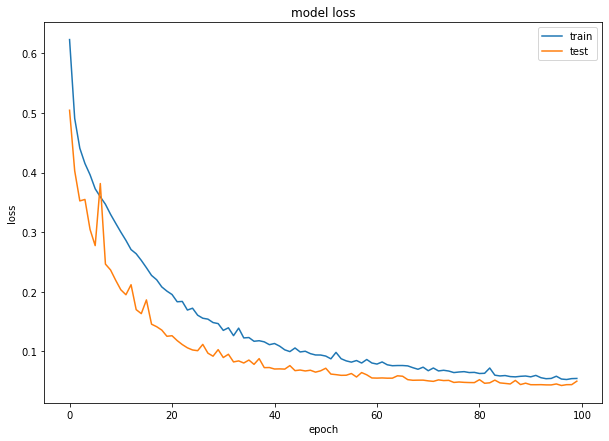

train loss= 0.054290056228637695
validation loss= 0.049723997712135315


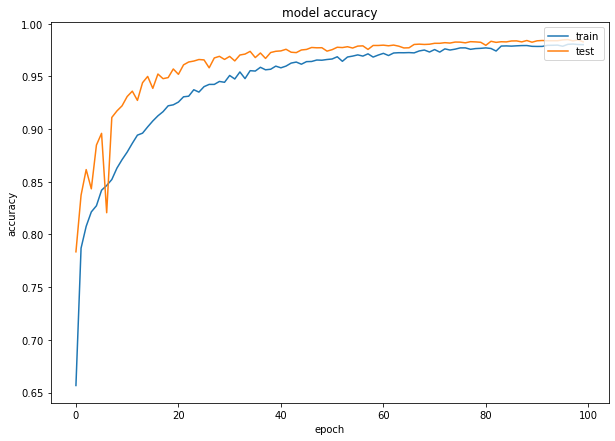

train accuracy= 0.9801037907600403
validation accuracy= 0.982775092124939


In [5]:
import matplotlib.pyplot as plt

# 학습 곡선을 나타내는 함수
def plot_loss_curve(history):
    plt.figure(figsize=(10, 7))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train loss=", history.history['loss'][-1])
    print("validation loss=", history.history['val_loss'][-1])
    
def plot_acc_curve(history):
    plt.figure(figsize=(10, 7))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train accuracy=", history.history['accuracy'][-1])
    print("validation accuracy=", history.history['val_accuracy'][-1])
    
plot_loss_curve(history)
plot_acc_curve(history)

In [5]:
model.save('C:/Users/s_csmscox/jupyterSave/eye_blink/eye_blink_CNN_ImgGen2.h5')

# Model Test

In [6]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = 'C:/Users/s_csmscox/jupyterSave/eye_blink/test'

batch_size = 50
img_size = 32

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size,img_size),                      
    batch_size=batch_size,     
    class_mode='categorical'                    
)

Found 16981 images belonging to 2 classes.


In [7]:
# 모델 평가

steps = 16981 / batch_size

print("-- Evaluate --")
scores = model.evaluate(test_generator, steps=steps)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
340/339 [==============================] - 6s 17ms/step - loss: 0.0465 - accuracy: 0.9839
accuracy: 98.39%


# Fine Tuning

In [2]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# gpu 메모리 최대로 잡는 것을 방지
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

model = load_model('C:/Users/s_csmscox/jupyterSave/eye_blink/eye_blink_CNN_imgGen1_FT.h5')
model.summary()

1 Physical GPUs, 1 Logical GPUs
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)       

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(patience = 15) # 조기종료 콜백함수 정의

# 데이터 개수 / batch_size
steps_per_epoch = 54332 / batch_size
val_steps = 13585 / batch_size

model.compile(optimizer=Adam(learning_rate=1e-7), loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[early_stopping],
                    verbose=1
                    )

Epoch 1/100
272/271 [==============================] - 34s 126ms/step - loss: 0.0288 - accuracy: 0.9894 - val_loss: 0.0330 - val_accuracy: 0.9881
Epoch 2/100
272/271 [==============================] - 35s 128ms/step - loss: 0.0282 - accuracy: 0.9899 - val_loss: 0.0324 - val_accuracy: 0.9884
Epoch 3/100
272/271 [==============================] - 35s 129ms/step - loss: 0.0271 - accuracy: 0.9903 - val_loss: 0.0321 - val_accuracy: 0.9886
Epoch 4/100
272/271 [==============================] - 34s 124ms/step - loss: 0.0254 - accuracy: 0.9908 - val_loss: 0.0320 - val_accuracy: 0.9888
Epoch 5/100
272/271 [==============================] - 34s 124ms/step - loss: 0.0255 - accuracy: 0.9903 - val_loss: 0.0320 - val_accuracy: 0.9889
Epoch 6/100
272/271 [==============================] - 34s 124ms/step - loss: 0.0251 - accuracy: 0.9910 - val_loss: 0.0320 - val_accuracy: 0.9890
Epoch 7/100
272/271 [==============================] - 34s 124ms/step - loss: 0.0255 - accuracy: 0.9906 - val_loss: 0.0321 -

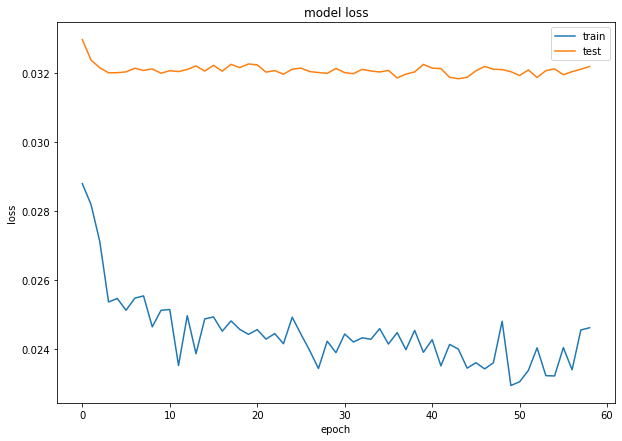

train loss= 0.024619778618216515
validation loss= 0.03218260034918785


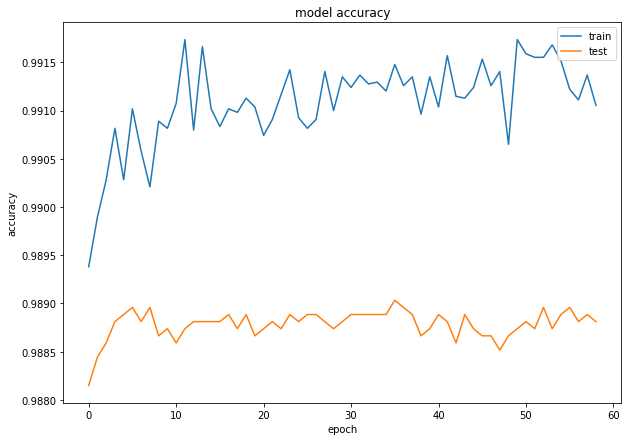

train accuracy= 0.9910550117492676
validation accuracy= 0.988811194896698


In [7]:
import matplotlib.pyplot as plt

# 학습 곡선을 나타내는 함수
def plot_loss_curve(history):
    plt.figure(figsize=(10, 7))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train loss=", history.history['loss'][-1])
    print("validation loss=", history.history['val_loss'][-1])
    
def plot_acc_curve(history):
    plt.figure(figsize=(10, 7))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train accuracy=", history.history['accuracy'][-1])
    print("validation accuracy=", history.history['val_accuracy'][-1])
    
plot_loss_curve(history)
plot_acc_curve(history)

In [8]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = 'C:/Users/s_csmscox/jupyterSave/eye_blink/test'

batch_size = 50
img_size = 32

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size,img_size),                      
    batch_size=batch_size,     
    class_mode='categorical'                    
)

Found 16981 images belonging to 2 classes.


In [9]:
# 모델 평가

steps = 16981 / batch_size

print("-- Evaluate --")
scores = model.evaluate(test_generator, steps=steps)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
340/339 [==============================] - 5s 15ms/step - loss: 0.0297 - accuracy: 0.9897
accuracy: 98.97%


In [11]:
model.save('C:/Users/s_csmscox/jupyterSave/eye_blink/eye_blink_CNN_ImgGen1_FT.h5')